<h1 align="center">Text Classification using TF-IDF based Features</h1>

In this notebook, we use a number of conventional feature engineering based approaches for sentiment classification.

In [1]:
import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
sentences = pd.read_csv(
    'imdb_labelled.txt', sep='\|', header=None, engine='python',
    names=['sentence', 'sentiment_label']
)

In [3]:
sentences.head()

,sentence,sentiment_label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [4]:
sentences.shape

(1000, 2)

Next we check for label imbalance.

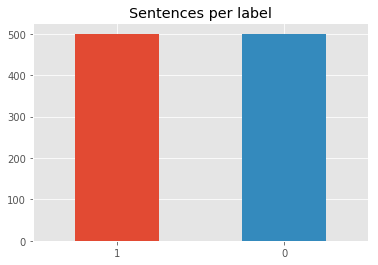

In [5]:
counts = sentences.sentiment_label.value_counts()
ax = counts.plot(kind='bar', rot=0, title='Sentences per label')

So this dataset has almost equal number of articles.

Next we analyze the distribution of words in the two class of articles.

In [6]:
from nltk.tokenize import word_tokenize

sentences = sentences.assign(word_list=sentences.sentence.apply(word_tokenize))
sentences.head()

,sentence,sentiment_label,word_list
0,"A very, very, very slow-moving, aimless movie ...",0,"[A, very, ,, very, ,, very, slow-moving, ,, ai..."
1,Not sure who was more lost - the flat characte...,0,"[Not, sure, who, was, more, lost, -, the, flat..."
2,Attempting artiness with black & white and cle...,0,"[Attempting, artiness, with, black, &, white, ..."
3,Very little music or anything to speak of.,0,"[Very, little, music, or, anything, to, speak,..."
4,The best scene in the movie was when Gerardo i...,1,"[The, best, scene, in, the, movie, was, when, ..."


In [7]:
# Create a counter for each label and update the relevant counter as we iterate over the entire dataframe
from collections import Counter


counters = {label: Counter() for label in sentences.sentiment_label.unique()}

for _, row in sentences.iterrows():
    c = counters[row.loc['sentiment_label']]
    c.update(row.loc['word_list'])
    
def make_df(label, c):
    """Make a DataFrame out of the counter with words in the index."""
    df = pd.DataFrame.from_dict(c, orient='index')
    df.columns =['sentiment_{}'.format(label)]
    return df

counter_dfs = {label: make_df(label, c) for label, c in counters.items()}

Now we look at the high-frequency and low-frequency words for sentiment label 0.

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

english_stopwords = set(stopwords.words('english'))

print(english_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'i', 'mustn', "shan't", 'each', 'off', 'an', "you're", 'couldn', 'not', 'don', 'ma', 'other', "hasn't", 'me', 'under', 'then', 'about', 'nor', 'do', 'm', 'myself', 'few', 'hers', 'from', 're', "you'd", 'that', 'can', 'above', "she's", 'whom', 'his', 'haven', "couldn't", 'but', 'during', 'than', 'its', "wasn't", 'am', 'd', 'itself', 'very', 'if', 'wasn', 'a', 'at', 'once', "shouldn't", 'they', "wouldn't", 'theirs', 'be', 'isn', 'before', "you'll", 'mightn', 'after', 've', 'this', "aren't", "doesn't", 'ain', 'hadn', "don't", 'the', 'wouldn', 'been', 'these', 'them', 'have', 'too', 'there', 'which', "that'll", 'out', "you've", 'o', 'didn', 'our', 'ourselves', 'so', 'you', 'it', 'doing', 'herself', 's', 'or', 'all', 'while', 'most', 'into', 'down', 'doesn', 'my', 'both', 'no', 'having', 'was', 'who', 'below', "mustn't", 'he', 'betw

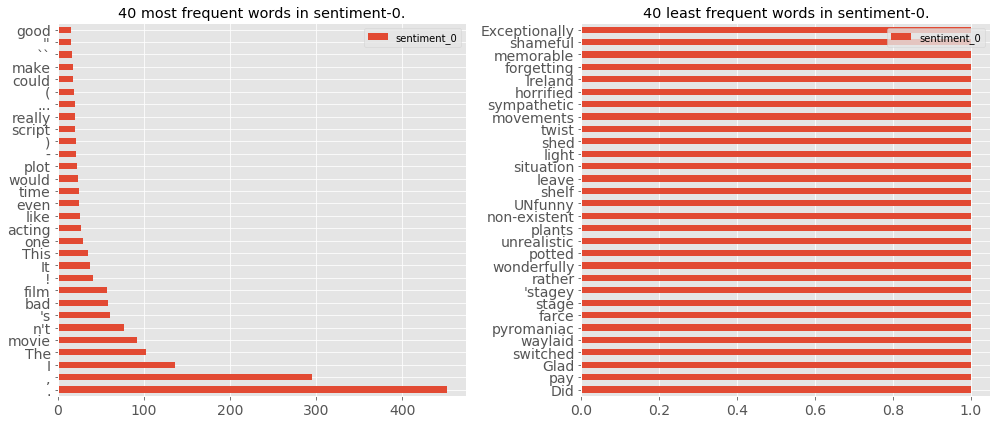

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sent_0_counts = counter_dfs[0].sort_values(by='sentiment_0', ascending=False)

sent_0_counts = sent_0_counts.drop(english_stopwords, errors='ignore')

sent_0_counts.head(30).plot(kind='barh', title='40 most frequent words in sentiment-0.', ax=ax[0], fontsize=14)
sent_0_counts.tail(30).plot(kind='barh', title='40 least frequent words in sentiment-0.', ax=ax[1], fontsize=14)

plt.tight_layout()

High-frequency and low-frequency words for sentiment label 1.

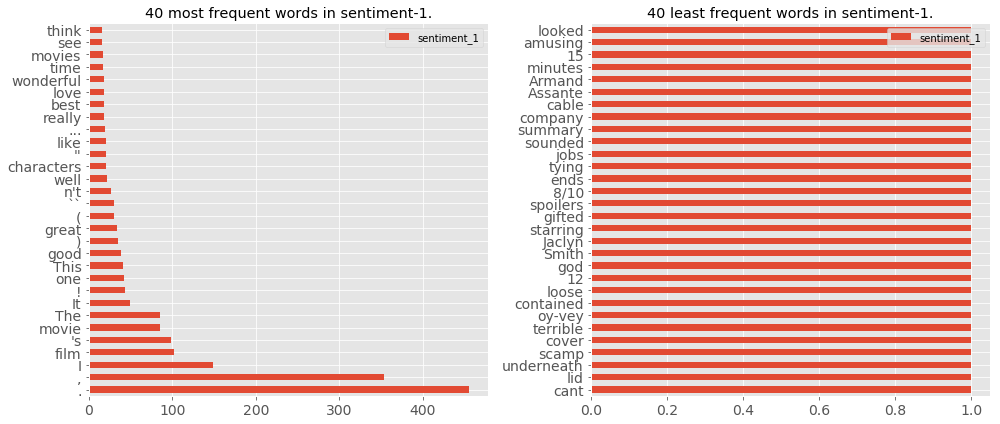

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sent_1_counts = counter_dfs[1].sort_values(by='sentiment_1', ascending=False)
sent_1_counts = sent_1_counts.drop(english_stopwords, errors='ignore')

sent_1_counts.head(30).plot(kind='barh', title='40 most frequent words in sentiment-1.', ax=ax[0], fontsize=14)
sent_1_counts.tail(30).plot(kind='barh', title='40 least frequent words in sentiment-1.', ax=ax[1], fontsize=14)

plt.tight_layout()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model.stochastic_gradient import SGDClassifier

model = SGDClassifier(alpha=1E-3, random_state=1234, max_iter=1000)
feature_calc = TfidfVectorizer(stop_words=english_stopwords)
pipeline = make_pipeline(feature_calc, model)

In [12]:
X_train = sentences.sample(frac=0.7, replace=False, random_state=1234).loc[:, 'sentence']
Y_train = sentences.sentiment_label.loc[X_train.index]

In [13]:
pipeline = pipeline.fit(X_train.values, Y_train.values)

In [14]:
X_test = sentences.drop(X_train.index, axis=0).loc[:, 'sentence']
Y_test = sentences.sentiment_label.loc[X_test.index]
predictions = pipeline.predict(X_test.values)

In [15]:
from sklearn.metrics import classification_report

results = classification_report(Y_test.values, predictions)
print(results)

             precision    recall  f1-score   support

          0       0.82      0.78      0.80       152
          1       0.78      0.82      0.80       148

avg / total       0.80      0.80      0.80       300

